In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
from sys import maxsize
from scipy.optimize import linprog

### Setup

In [65]:
# DATA EXTRACTION
df_BOM = pd.DataFrame({
    'operation': ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U'],
    'predecessor_operations': [[], [], ["A"], ["B"], ["C", "D"], ["E", "G"], ["H"], [], ["F"], [], [], [], ["J", "K", "L"], ["M"], ["N"], [], [], ["P", "Q"], ["R"], ["S", "U"], []],
    'end_product': [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0],
    'due_date': [None, None, None, None, None, None, None, None, 50.0, None, None, None, None, None, 80.0, None, None, None, None, 30.0, None],
    'processing_time': [3, 2, 1, 3, 1, 3, 5, 7, 4, 18, 12, 3, 5, 10, 4, 1, 8, 7, 5, 1, 8],
    'workcenter': ['WC#2', 'WC#1', 'WC#1', 'WC#2', 'WC#2', 'WC#2', 'WC#2', 'WC#3', 'WC#2', 'WC#1', 'WC#2', 'WC#3', 'WC#2', 'WC#2', 'WC#3', 'WC#2', 'WC#1', 'WC#1', 'WC#2', 'WC#3', 'WC#1'],
    'machine': ["M1", "M2", "M3", "M2", "M4", "M5", "M1", "M2", "M3", "M4", "M5", "M1", "M2", "M3", "M2", "M3", "M4", "M5", "M1", "M4", "M2"]
})
df_machine = pd.DataFrame({
    'workcenter': ["WC#1", "WC#2", "WC#3"],
    'M1': [3, 2, 3],
    'M2': [2, 1, 2],
    'M3': [1, 2, 1],
    'M4': [1, 1, 1],
    'M5': [1, 2, 3]
})
display(df_BOM)
display(df_machine)

class WorkCenter:
    def __init__(self, id, dict_machines={}):
        self.id = id
        self.machines = dict_machines
        # dict_machines = {'M1': [ [], [], [] ] }
        # this means that there are 3 M1 machines
        # the [] nested inside the list refers to the usage timings of the i-th M1 machine
        # for example: [ [(0,3), (4,5)], [], []]
        # means that the 1st machine is used from (0,3) and (4,5)

class Operation:
    def __init__(self, id, processing_time, workcenter, machine, due_date=None, successors=None):
        self.id = id
        # Precedence constraints
        self.successors = successors if successors else []

        # Workcenter and machine information
        self.workcenter = workcenter
        self.machine = machine

        # Times
        self.processing_time = processing_time
        self.start_time = None
        self.end_time = None
        self.due_date = None if due_date != due_date else due_date

        # Other
        self.scheduled = False

factory = {}
for idx, row in df_machine.iterrows():
    workcenter = row['workcenter']
    dict_machines = {}
    for machine in (df_machine.columns[1:]): 
        dict_machines[machine] = [[] for _ in range(row[machine])]
    # factory.append(WorkCenter(workcenter, dict_machines=dict_machines))
    factory[workcenter] = WorkCenter(workcenter, dict_machines=dict_machines)

,operation,predecessor_operations,end_product,due_date,processing_time,workcenter,machine
0,A,[],0,NaN,3,WC#2,M1
1,B,[],0,NaN,2,WC#1,M2
2,C,[A],0,NaN,1,WC#1,M3
3,D,[B],0,NaN,3,WC#2,M2
4,E,"[C, D]",0,NaN,1,WC#2,M4
5,F,"[E, G]",0,NaN,3,WC#2,M5
6,G,[H],0,NaN,5,WC#2,M1
7,H,[],0,NaN,7,WC#3,M2
8,I,[F],1,50.0,4,WC#2,M3
9,J,[],0,NaN,18,WC#1,M4


,workcenter,M1,M2,M3,M4,M5
0,WC#1,3,2,1,1,1
1,WC#2,2,1,2,1,2
2,WC#3,3,2,1,1,3


### Functions

In [66]:
def solve_lp_relaxation(c, A_eq, b_eq, A_ineq, b_ineq, lambda_=None):
    if lambda_ is not None:
        lagrangian_c = c + np.dot(lambda_, A_eq)
    else:
        lagrangian_c = c
    result = linprog(lagrangian_c, A_ub=A_ineq, b_ub=b_ineq, A_eq=A_eq, b_eq=b_eq, bounds=(0, None), method='highs')
    return result

def update_multipliers(lambda_, subgradients, step_size):
    lambda_ = lambda_ + step_size * subgradients
    return lambda_

def lagrangian_relaxation(operations, due_dates, factory, max_iterations=1000, tolerance=1e-5):
    n = len(operations)
    c = np.ones(n)
    
    # Initialize equality and inequality constraints 
    A_eq = np.zeros((n, n))
    b_eq = np.zeros(n)
    A_ineq = np.zeros((n, n))
    b_ineq = np.zeros(n)
    
    # Solve LP relaxation
    lp_result = solve_lp_relaxation(c, A_eq, b_eq, A_ineq, b_ineq)
    
    # Initialize Lagrangian multipliers
    lambda_ = np.random.rand(n)
    
    step_size = 1.0
    for iteration in range(max_iterations):
        # Solve the makespan subproblem
        makespan_result = solve_lp_relaxation(c, A_eq, b_eq, A_ineq, b_ineq, lambda_=lambda_)

        # Solve work center subproblems
        for wc in set(op.workcenter for op in operations.values()):
            wc_operations = [op for op in operations.values() if op.workcenter == wc]
            wc_indices = [list(operations.keys()).index(op.id) for op in wc_operations]
            
            wc_A_eq = A_eq[wc_indices][:, wc_indices]
            wc_b_eq = b_eq[wc_indices]
            wc_A_ineq = A_ineq[wc_indices][:, wc_indices]
            wc_b_ineq = b_ineq[wc_indices]
            wc_lambda = lambda_[wc_indices]
            wc_c = c[wc_indices]
            
            wc_result = solve_lp_relaxation(wc_c, wc_A_eq, wc_b_eq, wc_A_ineq, wc_b_ineq, lambda_=wc_lambda)
            
        # Compute subgradients for the work center
            wc_subgradients = wc_b_eq - np.dot(wc_A_eq, wc_result.x)
            wc_lambda = update_multipliers(wc_lambda, wc_subgradients, step_size)
        
        # Compute subgradients for the overall problem
        subgradients = b_eq - np.dot(A_eq, makespan_result.x)
        lambda_ = update_multipliers(lambda_, subgradients, step_size)
        
        # Generate upper and lower bounds (example logic, can be customized)
        upper_bound = np.sum(makespan_result.x)
        lower_bound = np.sum(lp_result.x)
        
        # Update bounds and check stopping criteria
        gap = upper_bound - lower_bound
        if gap < tolerance:
            break
        
        # Update step size 
        step_size *= 0.99
        
    return schedule_operations(operations, due_dates, factory, makespan_result.x)


def schedule_operations(operations, due_dates, factory, operation_times):
    scheduled_operations = []
    sorted_operations = np.argsort(operation_times)
    for op_index in sorted_operations:
        op_id = list(operations.keys())[op_index]
        operation = operations[op_id]
        if operation.successors:
            valid_start_times = [operations[succ_id].start_time for succ_id in operation.successors if operations[succ_id].start_time is not None]
            if valid_start_times:
                operation.end_time = min(valid_start_times)
            else:
                operation.end_time = due_dates[op_id] if due_dates[op_id] is not None else float('inf')
        else:
            operation.end_time = due_dates[op_id] if due_dates[op_id] is not None else float('inf')

        current_workcenter_id = operation.workcenter
        current_workcenter = factory[current_workcenter_id]             
        machine_type = operation.machine                                
        possible_machines = current_workcenter.machines[machine_type]   

        earliest_start_time = float('inf')
        selected_machine = None
        for machine_idx, machine_schedule in enumerate(possible_machines):
            print(machine_idx, machine_schedule)
            if not machine_schedule:  
                available_start_time = 0
            else:
                available_start_time = machine_schedule[0][1]  

            if available_start_time < earliest_start_time:
                earliest_start_time = available_start_time
                selected_machine = machine_schedule

        start_time = min(earliest_start_time, operation.end_time - operation.processing_time)
        end_time = start_time + operation.processing_time

        operation.start_time = start_time
        operation.end_time = end_time
        operation.scheduled = True
        selected_machine.append((start_time, end_time))
        scheduled_operations.append(operation)
    
    return scheduled_operations
        


def plot_gantt_chart(scheduled_operations):
    """
    Plots a Gantt chart for the scheduled operations.
    Inputs:
        - scheduled_operations      : list Operation(), a list of scheduled Operation objects.
    Output:
        - None 
        - Displays a Gantt chart.
    """
    fig, ax = plt.subplots(figsize=(10, 6))
    for op in scheduled_operations:
        ax.barh(op.id, op.processing_time, left=op.start_time, color='skyblue')
        ax.text(op.start_time + op.processing_time / 2, op.id, f'{op.start_time}-{op.end_time}', ha='center', va='center', color='black')

    ax.set_xlabel('Time')
    ax.set_ylabel('Operations')
    ax.set_title('Gantt Chart for Assembly Scheduling')
    plt.grid(True)
    plt.show()

def load_operations_from_df(df):
    """
    Loads operations from a DataFrame and creates Operation objects.    
    Inputs:
        - df: pandas DataFrame - A DataFrame containing BOM information with columns 
          ['part', 'operation', 'operation_id', 'components_required', 'processing_time', 'workcenter', 'predecessor_operations'].
    Output:
        - operations: dictionary, {operation_id: Operation()} - A dictionary of Operation objects.
    """
    operations = {}
    for idx, row in df.iterrows():
        operation_id = row['operation']
        successors = row['predecessor_operations']
        due_date = row['due_date']  
        operations[operation_id] = Operation(operation_id, row['processing_time'], row['workcenter'], row['machine'], due_date=due_date, successors=successors)
        
    return operations

def load_due_dates(df):
    """
    Generates due dates for each operation.    
    Inputs:
        - df: pandas DataFrame - A DataFrame containing BOM information.
    Output:
        - due_dates: dictionary, {operation_id: int} - A dictionary of due dates for each operation.
    """
    due_dates = {}
    for idx, row in df.iterrows():
        operation_id = row['operation']
        # Example due date assignment, this should be adjusted as per actual due dates
        due_dates[operation_id] = 20 - idx  # Example: descending due dates
    return due_dates



### Execution

0 []
1 []
0 [(0, 3)]
1 []
0 []
0 []
0 []
1 []
0 []
1 []
0 [(0, 1)]
1 []
0 []
0 []
1 []
2 []
0 []
0 []
1 []
0 [(0, 1)]
1 [(-3, 7)]
0 [(0, 4)]
1 []
0 [(0, 3)]
1 [(-3, 2)]
0 [(-2, 10)]
1 []
0 []
0 [(0, 5)]
0 []
0 []
1 []
0 [(-4, 4)]
0 [(0, 2)]
1 []


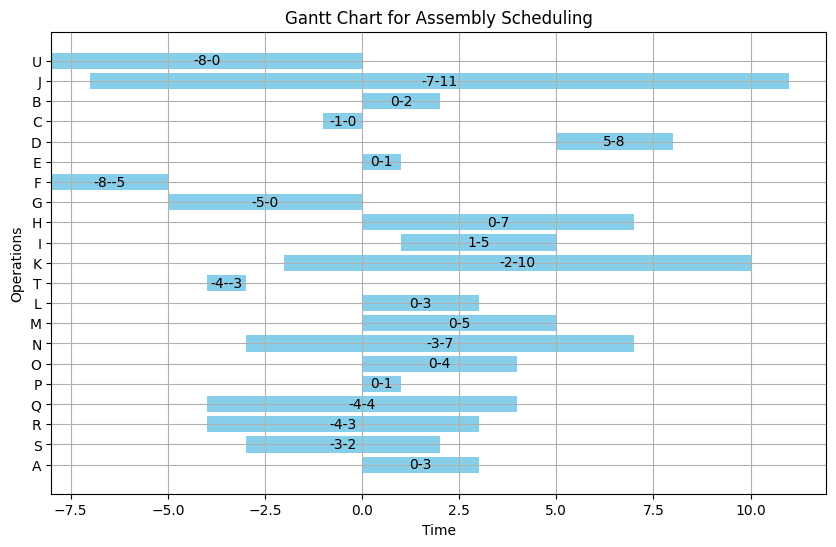

In [67]:
operations = load_operations_from_df(df_BOM)
due_dates = load_due_dates(df_BOM)

# Schedule operations
scheduled_operations = lagrangian_relaxation(operations, due_dates, factory)

# Plot Gantt chart
plot_gantt_chart(scheduled_operations)


In [68]:
for x, workcenter in factory.items():
    print(workcenter.machines)

{'M1': [[], [], []], 'M2': [[(0, 2)], [(-8, 0)]], 'M3': [[(-1, 0)]], 'M4': [[(-4, 4), (-7, 11)]], 'M5': [[(-4, 3)]]}
{'M1': [[(0, 3)], [(-3, 2), (-5, 0)]], 'M2': [[(0, 5), (5, 8)]], 'M3': [[(0, 1), (1, 5)], [(-3, 7)]], 'M4': [[(0, 1)]], 'M5': [[(-2, 10)], [(-8, -5)]]}
{'M1': [[(0, 3)], [], []], 'M2': [[(0, 4)], [(0, 7)]], 'M3': [[]], 'M4': [[(-4, -3)]], 'M5': [[], [], []]}


### Test Case

In [69]:
df_BOM = pd.DataFrame({
    'operation': ['F.10', 'F.20', 'D.10', 'C.10', 'A.10', 'A.20'],
    'predecessor_operations': [[], ['F.10'], [], ['D.10'], [], ['A.10']],
    'end_product': [0, 0, 0, 0, 0, 1],
    'due_date': [0, 0, 0, 0, 0, 14],
    'processing_time': [2, 3, 3, 1, 5, 2],
    'workcenter': ["WC#2", "WC#1", "WC#1", "WC#1", "WC#1", "WC#2"],
    'machine': ['M1', 'M1', 'M1', 'M1', 'M1', 'M1']
})
display(df_BOM)
df_machine = pd.DataFrame({
    'workcenter': ["WC#1", "WC#2"],
    'M1': [1, 1]
})
display(df_machine)

,operation,predecessor_operations,end_product,due_date,processing_time,workcenter,machine
0,F.10,[],0,0,2,WC#2,M1
1,F.20,[F.10],0,0,3,WC#1,M1
2,D.10,[],0,0,3,WC#1,M1
3,C.10,[D.10],0,0,1,WC#1,M1
4,A.10,[],0,0,5,WC#1,M1
5,A.20,[A.10],1,14,2,WC#2,M1


,workcenter,M1
0,WC#1,1
1,WC#2,1


0 [(0, 3)]
1 [(-3, 2), (-5, 0)]
0 []
1 []
2 []
0 [(-1, 2)]
1 []
2 []
0 [(-1, 2)]
1 [(0, 3)]
2 []
0 [(-1, 2)]
1 [(0, 3)]
2 [(-1, 0)]
0 [(0, 3)]
1 [(-3, 2), (-5, 0), (2, 4)]


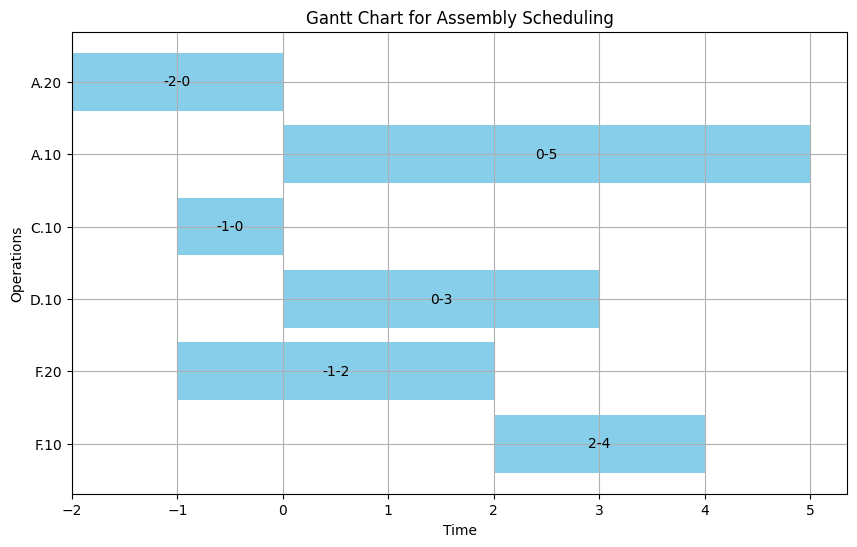

In [70]:
operations = load_operations_from_df(df_BOM)
due_dates = load_due_dates(df_BOM)

# # Schedule operations
scheduled_operations = lagrangian_relaxation(operations, due_dates, factory)

# # Plot Gantt chart
plot_gantt_chart(scheduled_operations)